In [1]:
#Liraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import datetime as dt
import json
from PIL import Image
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules



In [2]:
# import data
customers=pd.read_csv(r'CUSTOMERS.csv')
orders=pd.read_csv(r'ORDERS.csv')
reviews=pd.read_csv(r'ORDER_REVIEW_RATINGS.csv')
items=pd.read_csv(r'ORDER_ITEMS.csv')
products=pd.read_csv(r'PRODUCTS.csv')
payments=pd.read_csv(r'ORDER_PAYMENTS.csv')
sellers=pd.read_csv(r'SELLERS.csv')
location=pd.read_csv(r'GEO_LOCATION.csv')

In [3]:
#merging the data

data = pd.merge(customers, orders, on="customer_id")
data = data.merge(reviews, on="order_id")
data = data.merge(items, on="order_id")
data = data.merge(products, on="product_id")
data = data.merge(payments, on="order_id")
data = data.merge(sellers, on='seller_id')


data.info()
n2=data.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    118315 non-null  object 
 1   customer_unique_id             118315 non-null  object 
 2   customer_zip_code_prefix       118315 non-null  int64  
 3   customer_city                  118315 non-null  object 
 4   customer_state                 118315 non-null  object 
 5   order_id                       118315 non-null  object 
 6   order_status                   118315 non-null  object 
 7   order_purchase_timestamp       118315 non-null  object 
 8   order_approved_at              118300 non-null  object 
 9   order_delivered_carrier_date   117061 non-null  object 
 10  order_delivered_customer_date  115727 non-null  object 
 11  order_estimated_delivery_date  118315 non-null  object 
 12  review_id                     

In [4]:
#data info

df_name=('customers','location','orderitem','payments',
         'review','orders','products','sellers')
lst=[]
tmp=0
for i in customers,location,items,payments,reviews,orders,products,sellers:
    dic={}
    dic['dataset']=df_name[tmp]
    dic['n_rows']=i.shape[0]
    dic['n_cols']=i.shape[1]
    dic['null_vals']=i.isna().sum().sum()
    dic['dupl_vals']=i.duplicated().sum()
    tmp=tmp+1
    lst.append(dic)
ovv_check=pd.DataFrame(data=lst, columns=lst[0].keys())
ovv_check

,dataset,n_rows,n_cols,null_vals,dupl_vals
0,customers,99441,5,0,0
1,location,19015,5,0,0
2,orderitem,112650,7,0,0
3,payments,103886,5,0,0
4,review,100000,5,0,0
5,orders,99441,8,4908,0
6,products,32951,9,2461,0
7,sellers,3095,4,114,0


In [5]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [6]:
products.isnull().sum()

product_id                      0
product_category_name         623
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [7]:
#dropping null values
data.dropna(subset=["order_approved_at",
                    "order_delivered_carrier_date",
                    "order_delivered_customer_date",
                    "product_category_name", 
                    "product_name_lenght", 
                    "product_description_lenght",
                    "product_photos_qty",
                    "product_weight_g",
                    "product_length_cm", 
                    "product_height_cm",
                    "product_width_cm"],
            inplace=True)
n1=data.shape[0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114050 entries, 0 to 118314
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    114050 non-null  object 
 1   customer_unique_id             114050 non-null  object 
 2   customer_zip_code_prefix       114050 non-null  int64  
 3   customer_city                  114050 non-null  object 
 4   customer_state                 114050 non-null  object 
 5   order_id                       114050 non-null  object 
 6   order_status                   114050 non-null  object 
 7   order_purchase_timestamp       114050 non-null  object 
 8   order_approved_at              114050 non-null  object 
 9   order_delivered_carrier_date   114050 non-null  object 
 10  order_delivered_customer_date  114050 non-null  object 
 11  order_estimated_delivery_date  114050 non-null  object 
 12  review_id                     

In [8]:
#changing to datetime
data[['review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date']] = data[['review_creation_date', 'review_answer_timestamp',
    'order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

# 1 Detailed exploratory analysis

a. Define & calculate high level metrics like (Total Revenue, Total quantity, Total
products, Total categories, Total sellers, Total locations, Total channels, Total
payment methods etc…)

In [9]:
#total revenue
data.price.sum()

13685189.46

In [10]:
#total quantity
orders.order_id.count()

99441

In [11]:
#total products
products.product_id.count()

32951

In [12]:
#total categories
products.product_category_name.nunique()

71

In [13]:
#total sellers
sellers.seller_id.count()

3095

In [14]:
#total location
location.geolocation_city.nunique()

3809

In [15]:
#total no of sate
location.geolocation_state.nunique()

20

In [16]:
#total payment methods
payments.payment_type.nunique()

5

In [17]:
#average customer review

data.review_score.sum()/data.review_score.count()


4.0672424375274

In [18]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-16 15:22:00,2017-05-23 10:47:00,2017-05-25 10:35:00,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26,2017-05-30 22:34:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,5/22/2017 15:22,124.99,21.88,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,8577,Vijayawada,Andhra Pradesh
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,11/23/2017 0:47,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,11/23/2017 0:47,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Kodala,Orissa,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-08 22:22:00,2017-05-19 20:16:00,2017-05-26 09:54:00,2017-06-12,251191809e37c1cffc16865947c18a4d,3,2017-05-27,2017-05-28 02:43:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,5/22/2017 22:22,124.99,15.62,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,8577,Vijayawada,Andhra Pradesh
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Anklav,Gujarat,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-04 22:29:00,2018-02-19 18:21:00,2018-02-28 21:09:00,2018-03-22,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01,2018-03-02 11:11:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2/18/2018 21:29,106.99,30.59,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,8577,Vijayawada,Andhra Pradesh


# b.Understanding how many new customers acquired every month

In [19]:
# to get month
data['month']=data.order_purchase_timestamp.dt.month
data['year']=data.order_purchase_timestamp.dt.year
data['week']=data.order_purchase_timestamp.dt.week
data['day']=data.order_purchase_timestamp.dt.day

data

C:\Users\MOHANKUMAR\AppData\Local\Temp\ipykernel_31080\2239818426.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week']=data.order_purchase_timestamp.dt.week


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,month,year,week,day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-16 15:22:00,2017-05-23 10:47:00,2017-05-25 10:35:00,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26,2017-05-30 22:34:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,5/22/2017 15:22,124.99,21.88,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,8577,Vijayawada,Andhra Pradesh,5,2017,20,16
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,11/23/2017 0:47,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,11/23/2017 0:47,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Kodala,Orissa,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-08 22:22:00,2017-05-19 20:16:00,2017-05-26 09:54:00,2017-06-12,251191809e37c1cffc16865947c18a4d,3,2017-05-27,2017-05-28 02:43:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,5/22/2017 22:22,124.99,15.62,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,8577,Vijayawada,Andhra Pradesh,5,2017,18,7
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Anklav,Gujarat,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-04 22:29:00,2018-02-19 18:21:00,2018-02-28 21:09:00,2018-03-22,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01,2018-03-02 11:11:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2/18/2018 21:29,106.99,30.59,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,8577,Vijayawada,Andhra Pradesh,2,2018,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118308,59168d27c5da6a50e3d1f03d482e80b2,393c2ace23a135d0bcc7e70167448e16,47800,Pandariya,Chhattisgarh,c382d84d35f4d874b1f1c372f4bde27c,delivered,2018-07-20 09:42:00,2018-07-20 15:05:00,2018-07-23 11:53:00,2018-07-27 11:54:00,2018-08-14,ad5b887e12660a77a4e7f0b5130f36f3,5,2018-07-28,2018-07-30 16:48:00,1,731cf6fbf44cc64a9583fabe2c00750e,398cb257329ef7af7f1943a8974a3cbc,8/1/2018 15:05,145.90,15.47,Drinks,49.0,1879.0,1.0,2250.0,16.0,28.0,16.0,1,UPI,1,161.37,40285,Pedana,Andhra Pradesh,7,2018,29,20
118310,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,39920,Uchgaon,Maha

In [20]:
data['customer_type']=np.where(data['customer_id'].duplicated(),'Existing_customer','New_customer')

In [21]:
new=data.loc[data['customer_type']=='New_customer','customer_type']


In [22]:
new_cust=data.pivot_table(index=[data.month,data.year],columns=new,values='order_id',aggfunc='count')
new_cust

customer_type  New_customer
month year                 
1     2017              737
      2018             6901
2     2017             1592
      2018             6451
3     2017             2496
      2018             6884
4     2017             2241
      2018             6731
5     2017             3465
      2018             6714
6     2017             3084
      2018             6075
7     2017             3824
      2018             6110
8     2017             4129
      2018             6319
9     2017             4090
10    2016              268
      2017             4428
11    2017             7186
12    2016                1
      2017             5383

# c. Understand the retention of customers on month on month basis

In [23]:
existing=data.loc[data['customer_type']=='Existing_customer','customer_type']


In [24]:
existing_cust=data.pivot_table(index=[data.month,data.year],columns=existing,values='order_id',aggfunc='count')
existing_cust

customer_type  Existing_customer
month year                      
1     2017                   229
      2018                  1314
2     2017                   312
      2018                  1293
3     2017                   538
      2018                  1363
4     2017                   395
      2018                  1316
5     2017                   743
      2018                  1345
6     2017                   582
      2018                  1225
7     2017                   875
      2018                  1052
8     2017                   899
      2018                  1001
9     2017                   869
10    2016                    71
      2017                  1000
11    2017                  1575
12    2017                   944


# d. How the revenues from existing/new customers on month on month basis

In [25]:
data['Revenue']=data['price']+data['freight_value']

In [26]:
data.pivot_table(index=[data.month,data.year],columns=data['customer_type'],values='Revenue',aggfunc='sum')

customer_type  Existing_customer  New_customer
month year                                    
1     2017              23975.37     110473.96
      2018             144169.69     958276.34
2     2017              35746.80     239551.83
      2018             138281.33     863022.81
3     2017              58537.02     375480.75
      2018             150710.71    1002847.26
4     2017              48529.90     354464.26
      2018             142212.43    1022505.90
5     2017              95850.52     505715.87
      2018             156227.01    1006806.64
6     2017              60578.37     451376.58
      2018             144786.62     916854.65
7     2017              95121.67     510410.43
      2018             128397.70     931207.74
8     2017              93151.06     581267.78
      2018             113124.98     902380.90
9     2017             119375.23     619226.92
10    2016               6953.12      42389.65
      2017             108496.21     660777.87
11    2017             172590.95    1015648.66
12    2016                   NaN         19.62
      2017              96590.22     763247.18

# e. Understand the trends/seasonality of sales, quantity by category, location, month, week, day, time, channel, payment method etc…

In [27]:
cat_qty_sales = data.groupby('product_category_name').agg({'price': 'sum','product_id':'count'
                                                       }).reset_index().sort_values(by='product_id',ascending=False).rename(columns={'product_id':'quantity',
                                                                                                      'price':'sales'})
cat_qty_sales

,product_category_name,sales,quantity
7,Bed_Bath_Table,1092476.10,11815
43,Health_Beauty,1275820.41,9816
65,Sports_Leisure,995782.28,8790
39,Furniture_Decor,753048.18,8640
15,Computers_Accessories,926527.34,7963
...,...,...,...
3,Arts_And_Craftmanship,1814.01,24
52,La_Cuisine,2303.98,16
11,Cds_Dvds_Musicals,730.00,14
29,Fashion_Childrens_Clothes,519.95,7


<AxesSubplot:xlabel='product_category_name'>

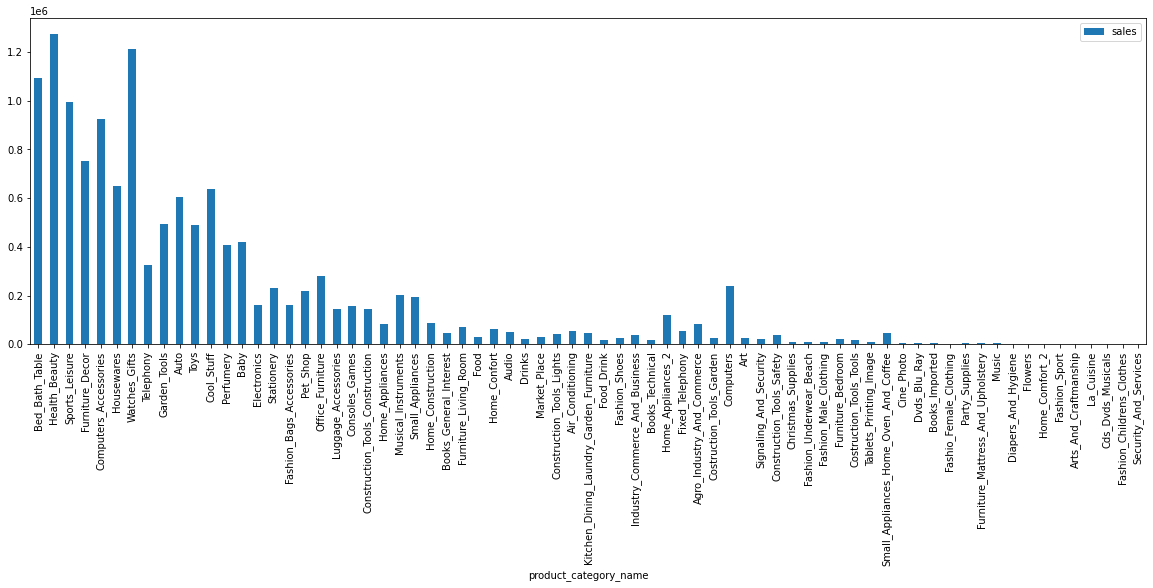

In [28]:

cat_qty_sales.plot(x="product_category_name",y="sales",kind='bar',figsize=(20,6),stacked=True)

<AxesSubplot:xlabel='product_category_name'>

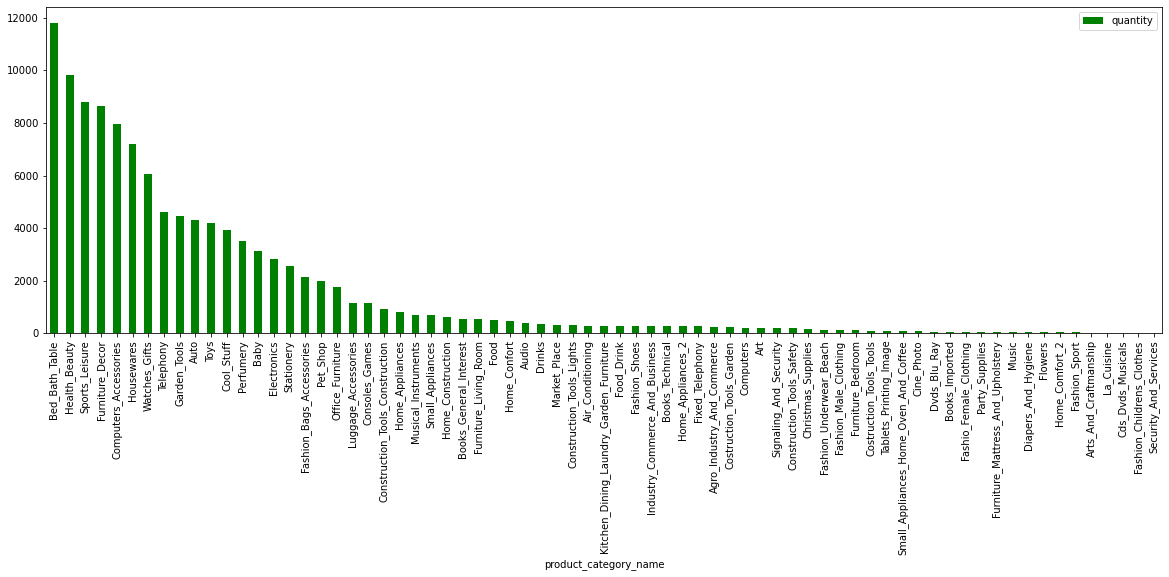

In [29]:

cat_qty_sales.plot(x="product_category_name",y="quantity",kind='bar',figsize=(20,6),stacked=True,color="green")

In [30]:
# Seasonality of sales, quantity by Month.
month_qty_sales = data.groupby('month').agg({'product_id':'count',
                                                       'price': 'sum'}).reset_index().sort_values(by='product_id',ascending=False).rename(columns={'product_id':'quantity','price':'sales'})
month_qty_sales

,month,quantity,sales
7,8,12348,1442952.23
4,5,12267,1527202.54
6,7,11861,1408388.95
2,3,11281,1357470.47
5,6,10966,1338624.46
3,4,10683,1352234.82
1,2,9648,1094126.26
0,1,9181,1062526.61
10,11,8761,1017007.79
11,12,6328,739558.09


<AxesSubplot:xlabel='month'>

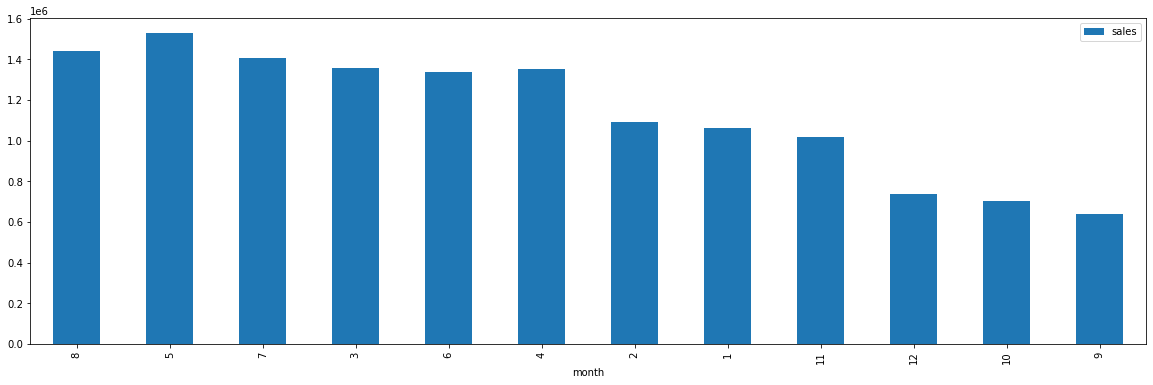

In [31]:
month_qty_sales.plot(x="month",y="sales",kind='bar',figsize=(20,6))

<AxesSubplot:xlabel='month'>

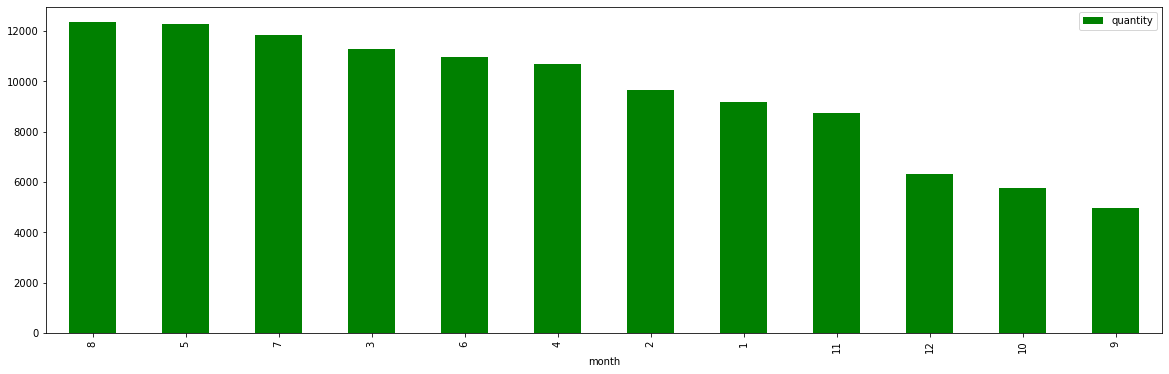

In [32]:
month_qty_sales.plot(x="month",y="quantity",kind='bar',figsize=(20,6),color="green")

In [33]:
# Seasonality of sales, quantity by Month.
loc_qty_sales = data.groupby('customer_state').agg({'product_id':'count','price': 'sum'}).reset_index().sort_values(by='product_id',ascending=False).rename(columns={'product_id':'quantity','price':'sales'})
loc_qty_sales

,customer_state,quantity,sales
0,Andhra Pradesh,69976,8125851.41
5,Gujarat,8583,1063151.68
2,Chhattisgarh,7197,942970.52
9,Karnataka,4392,528582.34
3,Delhi,3797,495279.12
11,Madhya Pradesh,3276,414428.71
6,Haryana,2562,312276.65
16,Tamil Nadu,2384,308104.61
12,Maharashtra,2253,277352.55
8,Jammu & Kashmir,1771,211634.03


<AxesSubplot:xlabel='customer_state'>

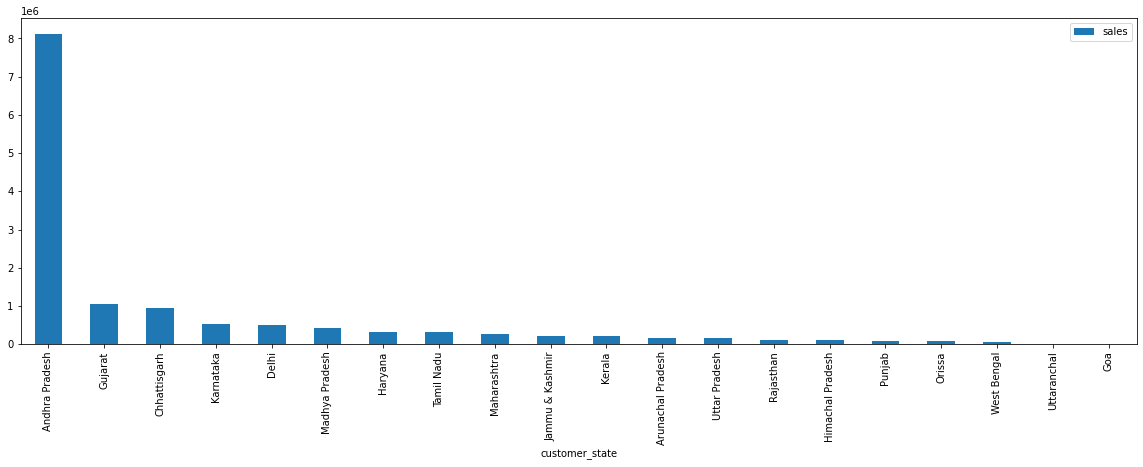

In [34]:
loc_qty_sales.plot(x="customer_state",y="sales",kind='bar',figsize=(20,6))

<AxesSubplot:xlabel='customer_state'>

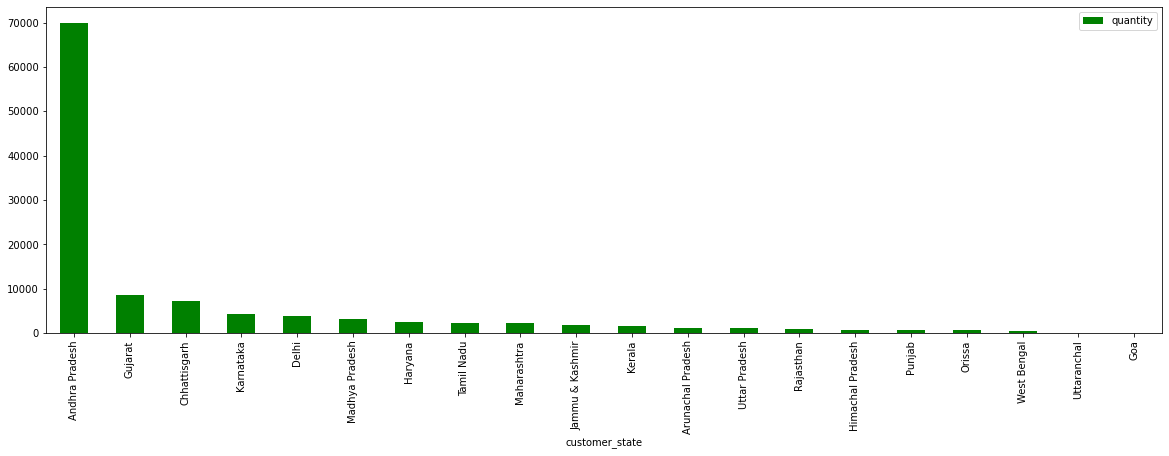

In [35]:
loc_qty_sales.plot(x="customer_state",y="quantity",kind='bar',figsize=(20,6),color="green")

In [36]:
# Seasonality of sales, quantity by Month.
week_qty_sales = data.groupby('week').agg({'product_id':'count','price': 'sum'}).reset_index().sort_values(by='product_id',ascending=False).rename(columns={'product_id':'quantity','price':'sales'})
week_qty_sales

,week,quantity,sales
46,47,3561,413247.86
30,31,3424,401818.31
31,32,3421,410117.09
19,20,3271,391519.07
32,33,3262,380692.03
18,19,3225,412403.50
28,29,3061,355028.06
29,30,2991,360209.63
17,18,2933,346176.76
8,9,2730,329469.78


<AxesSubplot:xlabel='week'>

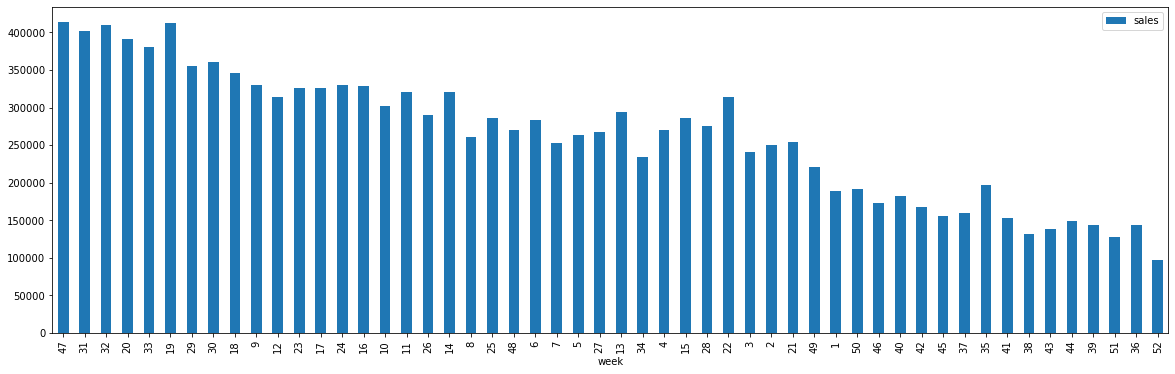

In [37]:
week_qty_sales.plot(x="week",y="sales",kind='bar',figsize=(20,6))

<AxesSubplot:xlabel='week'>

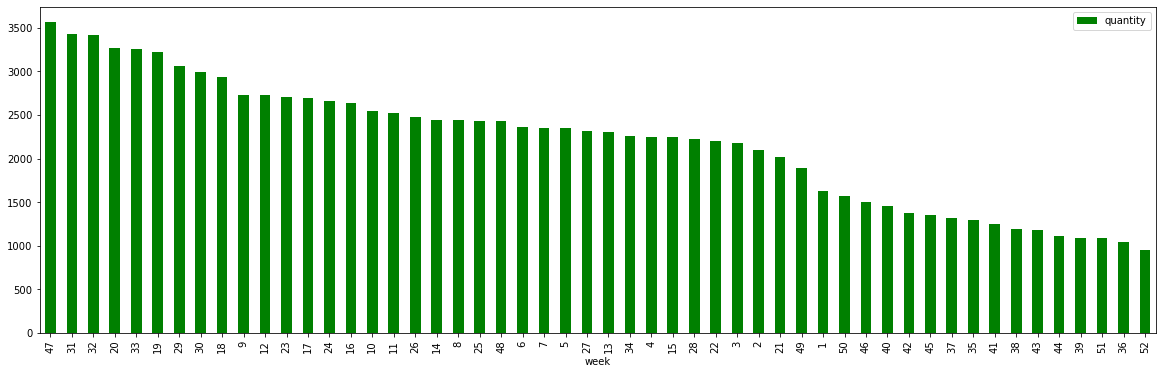

In [38]:
week_qty_sales.plot(x="week",y="quantity",kind='bar',figsize=(20,6),color="green")

In [39]:
day_qty_sales = data.groupby('day').agg({'product_id':'count','price': 'sum'}).reset_index().sort_values(by='product_id',ascending=False).rename(columns={'product_id':'quantity','price':'sales'})
day_qty_sales

,day,quantity,sales
23,24,4468,520008.84
15,16,4147,491869.83
14,15,3996,481275.07
17,18,3975,508111.57
4,5,3971,477447.77
18,19,3918,454926.20
5,6,3907,480750.92
3,4,3882,480261.09
6,7,3865,476251.75
25,26,3839,441078.93


<AxesSubplot:xlabel='day'>

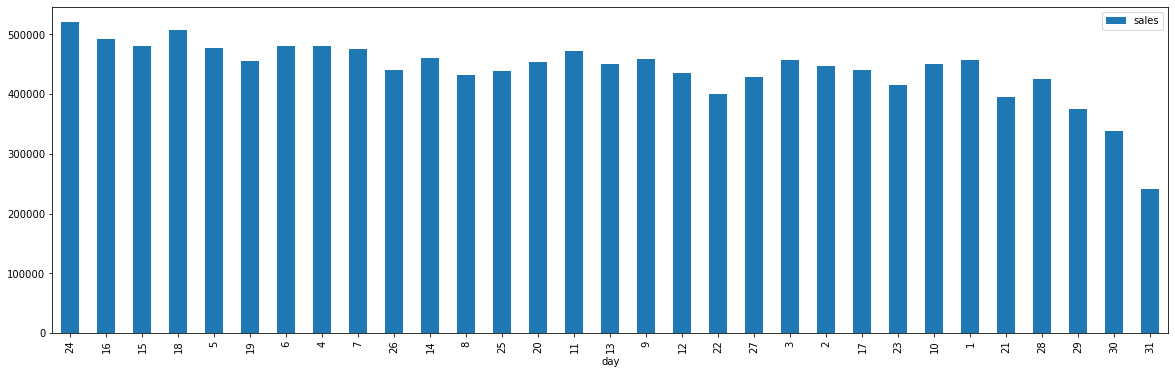

In [40]:
day_qty_sales.plot(x="day",y="sales",kind='bar',figsize=(20,6))

<AxesSubplot:xlabel='day'>

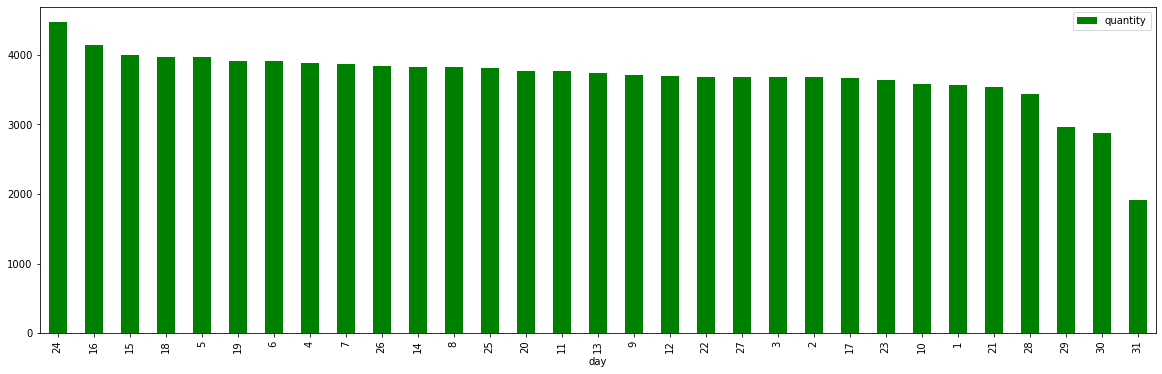

In [41]:
day_qty_sales.plot(x="day",y="quantity",kind='bar',figsize=(20,6),color="green")

# f. Popular Products by month, seller, state, category.

In [42]:
data['shipping_limit_date']=pd.to_datetime(data['shipping_limit_date'],format='%m/%d/%Y %H:%M')

In [43]:
data.product_id.value_counts().reset_index()

,index,product_id
0,aca2eb7d00ea1a7b8ebd4e68314663af,529
1,99a4788cb24856965c36a24e339b6058,516
2,422879e10f46682990de24d770e7f83d,508
3,389d119b48cf3043d311335e499d9c6b,403
4,368c6c730842d78016ad823897a372db,398
...,...,...
31609,d328462624ad874c591813fcfadbf1a0,1
31610,2072d4792ab7893ddbfc178948e0eb86,1
31611,8d72bd9268379ba4f39affd5ac80ac39,1
31612,3bfd31bd6ca35eba88eab292090ca291,1


In [44]:
#by month

In [45]:
d= pd.DataFrame()
for i in range(0,13):
    a = pd.DataFrame((data[data.shipping_limit_date.dt.month == i].groupby("product_id").shipping_limit_date.count()).reset_index().sort_values(by = "shipping_limit_date",ascending = False).head(1).product_id)
    d = pd.concat([d,a])

In [46]:
d['Month']=[1,2,3,4,5,6,7,8,9,10,11,12]
d.rename(columns={'product_id':'Popular_product'}).reset_index(drop=True)

,Popular_product,Month
0,aca2eb7d00ea1a7b8ebd4e68314663af,1
1,368c6c730842d78016ad823897a372db,2
2,aca2eb7d00ea1a7b8ebd4e68314663af,3
3,aca2eb7d00ea1a7b8ebd4e68314663af,4
4,53b36df67ebb7c41585e8d54d6772e08,5
5,99a4788cb24856965c36a24e339b6058,6
6,99a4788cb24856965c36a24e339b6058,7
7,e7cc48a9daff5436f63d3aad9426f28b,8
8,f1c7f353075ce59d8a6f3cf58f419c9c,9
9,422879e10f46682990de24d770e7f83d,10


In [47]:
#by seller

In [48]:
data.groupby('product_id')['seller_id'].count().sort_values(ascending=False).reset_index()

,product_id,seller_id
0,aca2eb7d00ea1a7b8ebd4e68314663af,529
1,99a4788cb24856965c36a24e339b6058,516
2,422879e10f46682990de24d770e7f83d,508
3,389d119b48cf3043d311335e499d9c6b,403
4,368c6c730842d78016ad823897a372db,398
...,...,...
31609,6ec96c91757fad0aecafc0ee7f262dcc,1
31610,6ec26b3516fecd18cda3001a9c48a242,1
31611,6ec18f98bd4eb7efc0989af1505a3f86,1
31612,6ebdbcab1f0dc7e1d3ecb01c1b140ade,1


In [49]:
#by state

In [50]:
data.customer_state.unique()

array(['Andhra Pradesh', 'Jammu & Kashmir', 'Orissa', 'Gujarat',
       'Rajasthan', 'Karnataka', 'Tamil Nadu', 'Maharashtra', 'Haryana',
       'Delhi', 'Uttar Pradesh', 'Chhattisgarh', 'Madhya Pradesh',
       'Punjab', 'Himachal Pradesh', 'Kerala', 'Arunachal Pradesh',
       'West Bengal', 'Goa', 'Uttaranchal'], dtype=object)

In [51]:
y=pd.DataFrame()
for i in data.customer_state.unique():
    b=data.loc[data.customer_state==i].groupby(['product_id','customer_state']).order_id.count().reset_index().sort_values(by = "order_id",ascending = False).head(1)
    y=pd.concat([y,b]) 
y

,product_id,customer_state,order_id
15663,aca2eb7d00ea1a7b8ebd4e68314663af,Andhra Pradesh,340
695,89b190a046022486c635022524a974a8,Jammu & Kashmir,15
390,aca2eb7d00ea1a7b8ebd4e68314663af,Orissa,7
3359,aca2eb7d00ea1a7b8ebd4e68314663af,Gujarat,51
488,afc6bc70dc56fcf15c7f9f1e4bc67dda,Rajasthan,7
729,422879e10f46682990de24d770e7f83d,Karnataka,25
1214,b532349fe46b38fbc7bb3914c1bdae07,Tamil Nadu,13
1006,99a4788cb24856965c36a24e339b6058,Maharashtra,13
403,35afc973633aaeb6b877ff57b2793310,Haryana,17
843,53759a2ecddad2bb87a079a1f1519f73,Delhi,25


In [52]:
#by category

In [53]:
data.groupby(['product_category_name']).product_id.count().reset_index().sort_values(by='product_id',ascending=False)

,product_category_name,product_id
7,Bed_Bath_Table,11815
43,Health_Beauty,9816
65,Sports_Leisure,8790
39,Furniture_Decor,8640
15,Computers_Accessories,7963
...,...,...
3,Arts_And_Craftmanship,24
52,La_Cuisine,16
11,Cds_Dvds_Musicals,14
29,Fashion_Childrens_Clothes,7


# g. Popular categories by state, month

In [54]:
# Popular category by month
z=pd.DataFrame()
for i in range(0,13):
    ab = pd.DataFrame((data[data.shipping_limit_date.dt.month == i].groupby("product_category_name").shipping_limit_date.count()).reset_index().sort_values(by = "shipping_limit_date",ascending = False).head(1).product_category_name)
    z= pd.concat([z,ab])
z['Month']=[1,2,3,4,5,6,7,8,9,10,11,12]
z.reset_index()

,index,product_category_name,Month
0,35,Furniture_Decor,1
1,6,Bed_Bath_Table,2
2,12,Computers_Accessories,3
3,7,Bed_Bath_Table,4
4,7,Bed_Bath_Table,5
5,6,Bed_Bath_Table,6
6,7,Bed_Bath_Table,7
7,7,Bed_Bath_Table,8
8,6,Bed_Bath_Table,9
9,6,Bed_Bath_Table,10


In [55]:
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,month,year,week,day,customer_type,Revenue
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-16 15:22:00,2017-05-23 10:47:00,2017-05-25 10:35:00,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26,2017-05-30 22:34:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:00,124.99,21.88,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,8577,Vijayawada,Andhra Pradesh,5,2017,20,16,New_customer,146.87
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,New_customer,137.89
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,Existing_customer,137.89
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Kodala,Orissa,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-08 22:22:00,2017-05-19 20:16:00,2017-05-26 09:54:00,2017-06-12,251191809e37c1cffc16865947c18a4d,3,2017-05-27,2017-05-28 02:43:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:00,124.99,15.62,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,8577,Vijayawada,Andhra Pradesh,5,2017,18,7,New_customer,140.61
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Anklav,Gujarat,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-04 22:29:00,2018-02-19 18:21:00,2018-02-28 21:09:00,2018-03-22,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01,2018-03-02 11:11:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:00,106.99,30.59,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,8577,Vijayawada,Andhra Pradesh,2,2018,5,3,New_customer,137.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118308,59168d27c5da6a50e3d1f03d482e80b2,393c2ace23a135d0bcc7e70167448e16,47800,Pandariya,Chhattisgarh,c382d84d35f4d874b1f1c372f4bde27c,delivered,2018-07-20 09:42:00,2018-07-20 15:05:00,2018-07-23 11:53:00,2018-07-27 11:54:00,2018-08-14,ad5b887e12660a77a4e7f0b5130f36f3,5,2018-07-28,2018-07-30 16:48:00,1,731cf6fbf44cc64a9583fabe2c00750e,398cb257329ef7af7f1943a8974a3cbc,2018-08-01 15:05:00,145.90,15.47,Drinks,49.0,1879.0,1.0,2250.0,16

In [56]:
s=pd.DataFrame()
for i in data.customer_state.unique():
    b=data.loc[data.customer_state==i].groupby(['product_id','customer_state']).order_id.count().reset_index().sort_values(by = "order_id",ascending = False).head(1)
    s=pd.concat([s,b]) 
s

,product_id,customer_state,order_id
15663,aca2eb7d00ea1a7b8ebd4e68314663af,Andhra Pradesh,340
695,89b190a046022486c635022524a974a8,Jammu & Kashmir,15
390,aca2eb7d00ea1a7b8ebd4e68314663af,Orissa,7
3359,aca2eb7d00ea1a7b8ebd4e68314663af,Gujarat,51
488,afc6bc70dc56fcf15c7f9f1e4bc67dda,Rajasthan,7
729,422879e10f46682990de24d770e7f83d,Karnataka,25
1214,b532349fe46b38fbc7bb3914c1bdae07,Tamil Nadu,13
1006,99a4788cb24856965c36a24e339b6058,Maharashtra,13
403,35afc973633aaeb6b877ff57b2793310,Haryana,17
843,53759a2ecddad2bb87a079a1f1519f73,Delhi,25


# h. List top 10 most expensive products sorted by price

In [57]:
data.groupby('product_id').price.sum().reset_index().sort_values(by='price',ascending=False).head(10)

,product_id,price
23114,bb50f2e236e5eea0100680137654686c,68485.00
13494,6cdd53843498f92890544667809f1595,54702.00
26504,d6160fb7873f184099d9bc95e30376af,53998.84
25948,d1c427060a0f73f6b889a5c7c61f2ac4,47547.45
18943,99a4788cb24856965c36a24e339b6058,45509.86
4799,25c38557cf793876c5abdd5931f922db,44829.32
7736,3dd2a17168ec895c781a9191c1e95ad7,41382.40
10415,53b36df67ebb7c41585e8d54d6772e08,37929.42
21232,aca2eb7d00ea1a7b8ebd4e68314663af,37743.60
11852,5f504b3a1c75b73d6151be81eb05bdc9,37733.90


# 2. Performing Customers/sellers Segmentation
a. Divide the customers into groups based on the revenue generated

In [58]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,month,year,week,day,customer_type,Revenue
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-16 15:22:00,2017-05-23 10:47:00,2017-05-25 10:35:00,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26,2017-05-30 22:34:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:00,124.99,21.88,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,8577,Vijayawada,Andhra Pradesh,5,2017,20,16,New_customer,146.87
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,New_customer,137.89
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,Existing_customer,137.89
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Kodala,Orissa,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-08 22:22:00,2017-05-19 20:16:00,2017-05-26 09:54:00,2017-06-12,251191809e37c1cffc16865947c18a4d,3,2017-05-27,2017-05-28 02:43:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:00,124.99,15.62,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,8577,Vijayawada,Andhra Pradesh,5,2017,18,7,New_customer,140.61
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Anklav,Gujarat,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-04 22:29:00,2018-02-19 18:21:00,2018-02-28 21:09:00,2018-03-22,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01,2018-03-02 11:11:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:00,106.99,30.59,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,8577,Vijayawada,Andhra Pradesh,2,2018,5,3,New_customer,137.58


In [59]:
cust_revenue = data.groupby('customer_unique_id')['Revenue'].sum().reset_index()
cust_revenue.rename(columns ={'revenue':'total_spend_amt'} , inplace = True)
cust_revenue.head(2)

,customer_unique_id,Revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19


In [60]:
cust_revenue['cust_rev_group'] = pd.cut(cust_revenue.Revenue,
                               bins= np.arange(0 , 15000, 1000),
                               labels=['0-1000','1000-2000','2000-3000','3000-4000',
                                       '4000-5000','5000-6000','6000-7000','7000-8000','8000-9000',
                                      '9000-10000','10000-11000','11000-12000','12000-13000','13000-14000'])
cust_revenue

,customer_unique_id,Revenue,cust_rev_group
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,0-1000
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0-1000
2,0000f46a3911fa3c0805444483337064,86.22,0-1000
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,0-1000
4,0004aac84e0df4da2b147fca70cf8255,196.89,0-1000
...,...,...,...
92057,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,2000-3000
92058,fffea47cd6d3cc0a88bd621562a9d061,84.58,0-1000
92059,ffff371b4d645b6ecea244b27531430a,112.46,0-1000
92060,ffff5962728ec6157033ef9805bacc48,133.69,0-1000


# b. Divide the sellers into groups based on the revenue generated


In [61]:
sellers_rev = data.groupby('seller_id')['price'].sum().reset_index()

In [62]:
sellers_rev.rename( columns = {'price':'Revenue'}, inplace= True)

In [63]:
sellers_rev['sellers_rev_group'] = pd.cut(sellers_rev.Revenue,
                               bins= np.arange(0 , 300000, 50000),
                               labels=['0-50000','50000-100000','100000-150000','150000-200000',
                                       '200000-250000'])
sellers_rev

,seller_id,Revenue,sellers_rev_group
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,0-50000
1,001cca7ae9ae17fb1caed9dfb1094831,24655.93,0-50000
2,002100f778ceb8431b7a1020ff7ab48f,1285.20,0-50000
3,004c9cd9d87a3c30c522c48c4fc07416,19016.04,0-50000
4,00720abe85ba0859807595bbf045a33b,1007.50,0-50000
...,...,...,...
2907,ffc470761de7d0232558ba5e786e57b7,1640.03,0-50000
2908,ffdd9f82b9a447f6f8d4b91554cc7dd3,2140.80,0-50000
2909,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,0-50000
2910,fffd5413c0700ac820c7069d66d98c89,8833.60,0-50000


# 3. Cross-Selling (Which products are selling together)

Cross selling of products for Adilabad

In [64]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,month,year,week,day,customer_type,Revenue
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-16 15:22:00,2017-05-23 10:47:00,2017-05-25 10:35:00,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26,2017-05-30 22:34:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:00,124.99,21.88,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,8577,Vijayawada,Andhra Pradesh,5,2017,20,16,New_customer,146.87
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,New_customer,137.89
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,Existing_customer,137.89
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Kodala,Orissa,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-08 22:22:00,2017-05-19 20:16:00,2017-05-26 09:54:00,2017-06-12,251191809e37c1cffc16865947c18a4d,3,2017-05-27,2017-05-28 02:43:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:00,124.99,15.62,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,8577,Vijayawada,Andhra Pradesh,5,2017,18,7,New_customer,140.61
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Anklav,Gujarat,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-04 22:29:00,2018-02-19 18:21:00,2018-02-28 21:09:00,2018-03-22,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01,2018-03-02 11:11:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:00,106.99,30.59,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,8577,Vijayawada,Andhra Pradesh,2,2018,5,3,New_customer,137.58


In [65]:
df=data
df['product'] = df['product_id'].str.strip()
df.dropna(axis=0, subset=['order_id'], inplace=True)
df['order_id'] = df['order_id'].astype('str')
df = df[~df['order_id'].str.contains('C')]
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,month,year,week,day,customer_type,Revenue,product
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Adilabad,Andhra Pradesh,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-16 15:22:00,2017-05-23 10:47:00,2017-05-25 10:35:00,2017-06-05,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26,2017-05-30 22:34:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:00,124.99,21.88,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,2,146.87,8577,Vijayawada,Andhra Pradesh,5,2017,20,16,New_customer,146.87,a9516a079e37a9c9c36b9b78b10169e8
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,New_customer,137.89,a9516a079e37a9c9c36b9b78b10169e8
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,Rehambal,Jammu & Kashmir,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-10 00:47:00,2017-11-22 01:43:00,2017-11-28 00:09:00,2017-12-19,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29,2017-12-01 19:41:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:00,112.99,24.90,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,1,275.79,8577,Vijayawada,Andhra Pradesh,11,2017,45,9,Existing_customer,137.89,a9516a079e37a9c9c36b9b78b10169e8
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,Kodala,Orissa,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-08 22:22:00,2017-05-19 20:16:00,2017-05-26 09:54:00,2017-06-12,251191809e37c1cffc16865947c18a4d,3,2017-05-27,2017-05-28 02:43:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:00,124.99,15.62,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,7,140.61,8577,Vijayawada,Andhra Pradesh,5,2017,18,7,New_customer,140.61,a9516a079e37a9c9c36b9b78b10169e8
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,Anklav,Gujarat,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-04 22:29:00,2018-02-19 18:21:00,2018-02-28 21:09:00,2018-03-22,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01,2018-03-02 11:11:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:00,106.99,30.59,Office_Furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1,credit_card,10,137.58,8577,Vijayawada,Andhra Pradesh,2,2018,5,3,New_customer,137.58,a9516a079e37a9c9c36b9b78b10169e8


In [66]:
basket = (df[df['customer_city'] =="Adilabad"]
          .groupby(['order_id', 'product_id'])['order_item_id']
          .count().unstack().reset_index().fillna(0)
          .set_index('order_id'))
basket

product_id,00088930e925c41fd95ebfe695fd2655,013e6676e0e3529e5909ff54370daddf,01c9a70868bec5b748c67fcc26ce5895,02ce467092b184e71d3967d29110adc1,0354c6a8cb8961e29b70e564b93861fe,04c4a4b9c924494fcf82e0fba966f955,05df88a280f9c6edca3b2f5f9b3e75ad,06f18114503e7543d81252fd61a53df8,07f381c65e8e66460c07781b9b1b8834,090d6db6ad440d35cef0726b5a8bec14,09364ccfda8448d03ae4082f6044b16e,0a45c6bb3a03e8c13228d4200cb964c2,0cbca89e0ecfd4fe92dff4f1c27a0487,0e87ff05afa3ddd73b7920ff4587e0a4,0f3de29f8370072525a20385ebbe889a,1108e11fe60f34cb7f2a832d96c17137,120fa011365fc39efe382cba4e50999e,151d7733b44e0c7b292d7e2efb5424a2,154e7e31ebfa092203795c972e5804a6,15859e3a8aaa3c192c10a91d8722abd5,1613b819ab5dae53aead2dbb4ebdb378,16280ca280a86fee2ba3c928ed04439f,165f86fe8b799a708a20ee4ba125c289,196616257eff8bc851dc4fc041cbbbe9,19d97e807df39d7af6311ba423eaecc3,1b9eb27d35b89e35c8b32fa9902cdba9,1c3872bb3c0bc580a0f1cd3f1cc869c5,1d6d7be70107889e3193819aca4dc1dc,243bb58796ed2164b831fb75e1241888,281a67fd770c975ee1a7c842468fb3b5,2a2d22ae30e026f1893083c8405ca522,2a71535169f1f7a56b266e6877bb8cf9,2b4609f8948be18874494203496bc318,2bf749803c44ed8670283404d3c2140b,2dd91cf063cf57cb0eebef072746daab,2fcef9efef474266c020ab6ccf2c61a8,33bfc11487d18d2405f84661bc164f0f,368c6c730842d78016ad823897a372db,3713f19c71c4be21ced80738e2fa49bc,39fbb313b6c8c6cc28e358f37e3068c1,3a806ac1ab98107febb4ffcf38bc1fac,3ba2b0de14984ce8f072c58be8d701dd,3dd2a17168ec895c781a9191c1e95ad7,3f14d740544f37ece8a9e7bc8349797e,40cb7bb3d30559b9b6c4fb62bc837962,422879e10f46682990de24d770e7f83d,437c05a395e9e47f9762e677a7068ce7,45dc66388e0aeec2e8baab5572f2fa44,4910917f05092f331bf3a477f791cc01,4aaf2a3c07e710f592c5015ce8dc7547,...,bd5110ad5f718f7c3dded1c18b4b135e,bf5d132b4d30a18970b8ee7798725af1,bfde0959ec5f62871403b693d2fe68d2,c403e106353e1aa40efe783ecb39ed7a,c6ea63369936552872ae890c82175b4b,c7b3cf9de7be95b3e09e7a63315685eb,c7fd13b5e515bffdab855d0812842edb,cb7d42475660f66a519c76f55715cd32,cba1a3cf642112a308969fdb2c9f687d,ccb162ed569f47d83f62aebd5700d7ad,ccb3df28522945422e24b108603a1d04,ce98361ef1341e15087ae4b1b2c53fdd,cfc665b462ccc3a43b1a1283e678b1a0,d22bbc02259111e107ee7916637d4791,d370e908175e2f3b39bb7fd33fd4c530,d38a6b2305a426ee95a1b270cafc39f1,d4e19eb1e5c5d6194af618d3a67de4e6,d5991653e037ccb7af6ed7d94246b249,db5efde3ad0cc579b130d71c4b2db522,dd4c3b4ab7e001aaf385ea2e68952030,ddb67d084003da7eb28d3e2992a5971c,ddfaa1c2e19f82a47043c5f5ee1376d1,deafef42415ecde158b2a30ed7981e65,e0d64dcfaa3b6db5c54ca298ae101d05,e145fe0be63a7cfdb3b2d57c6769cec1,e15cee02291017f6f12b4115ffb417e6,e1da6ab77f4859eb17950e5df1c0f815,e251ebd2858be1aa7d9b2087a6992580,e3144d54af34133a585de8b475dfc57b,e44f675b60b3a3a2453ec36421e06f0f,e5658bcc41cb5f1d1a0b3bde488c2f98,e5ae72c62ebfa708624f5029d609b160,eab67bf937aaadc19f83383a331d2dd9,ec2d43cc59763ec91694573b31f1c29a,ee3cfb33869693f2a7e8417c795d8cfc,ee406bf28024d97771c4b1e8b7e8e219,ee5329ffbe604bebcf84b2fd7792024e,eebbed5ed3b134eceb717496c47652ba,ef59f328cef34c7b309bb12e86b6418b,ef66e63137bdd1b2e44aa968646fc1e3,f1c7f353075ce59d8a6f3cf58f419c9c,f2bb1681ac26e3993d10ff79cba282d5,f35927953ed82e19d06ad3aac2f06353,f4efad625ed5878a2e7589dfb31c747f,f9421e9d9b4689dd804adbdb8c712d39,f9812ff329fb8141750f67a3e6551907,fa052b8f8028fd0a75b6b2671b1e1cfb,fca62108387e25005784da2f551466a1,fcad6e5643f855de4b616a24e6dd25e4,fe7f10e5c9d36a294333b0c35ccc24ad
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00e7ee1b050b8499577073aeb2a297a1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
027ae252d37e5527c2e109e268b222e2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [67]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

basket_sets

product_id,00088930e925c41fd95ebfe695fd2655,013e6676e0e3529e5909ff54370daddf,01c9a70868bec5b748c67fcc26ce5895,02ce467092b184e71d3967d29110adc1,0354c6a8cb8961e29b70e564b93861fe,04c4a4b9c924494fcf82e0fba966f955,05df88a280f9c6edca3b2f5f9b3e75ad,06f18114503e7543d81252fd61a53df8,07f381c65e8e66460c07781b9b1b8834,090d6db6ad440d35cef0726b5a8bec14,09364ccfda8448d03ae4082f6044b16e,0a45c6bb3a03e8c13228d4200cb964c2,0cbca89e0ecfd4fe92dff4f1c27a0487,0e87ff05afa3ddd73b7920ff4587e0a4,0f3de29f8370072525a20385ebbe889a,1108e11fe60f34cb7f2a832d96c17137,120fa011365fc39efe382cba4e50999e,151d7733b44e0c7b292d7e2efb5424a2,154e7e31ebfa092203795c972e5804a6,15859e3a8aaa3c192c10a91d8722abd5,1613b819ab5dae53aead2dbb4ebdb378,16280ca280a86fee2ba3c928ed04439f,165f86fe8b799a708a20ee4ba125c289,196616257eff8bc851dc4fc041cbbbe9,19d97e807df39d7af6311ba423eaecc3,1b9eb27d35b89e35c8b32fa9902cdba9,1c3872bb3c0bc580a0f1cd3f1cc869c5,1d6d7be70107889e3193819aca4dc1dc,243bb58796ed2164b831fb75e1241888,281a67fd770c975ee1a7c842468fb3b5,2a2d22ae30e026f1893083c8405ca522,2a71535169f1f7a56b266e6877bb8cf9,2b4609f8948be18874494203496bc318,2bf749803c44ed8670283404d3c2140b,2dd91cf063cf57cb0eebef072746daab,2fcef9efef474266c020ab6ccf2c61a8,33bfc11487d18d2405f84661bc164f0f,368c6c730842d78016ad823897a372db,3713f19c71c4be21ced80738e2fa49bc,39fbb313b6c8c6cc28e358f37e3068c1,3a806ac1ab98107febb4ffcf38bc1fac,3ba2b0de14984ce8f072c58be8d701dd,3dd2a17168ec895c781a9191c1e95ad7,3f14d740544f37ece8a9e7bc8349797e,40cb7bb3d30559b9b6c4fb62bc837962,422879e10f46682990de24d770e7f83d,437c05a395e9e47f9762e677a7068ce7,45dc66388e0aeec2e8baab5572f2fa44,4910917f05092f331bf3a477f791cc01,4aaf2a3c07e710f592c5015ce8dc7547,...,bd5110ad5f718f7c3dded1c18b4b135e,bf5d132b4d30a18970b8ee7798725af1,bfde0959ec5f62871403b693d2fe68d2,c403e106353e1aa40efe783ecb39ed7a,c6ea63369936552872ae890c82175b4b,c7b3cf9de7be95b3e09e7a63315685eb,c7fd13b5e515bffdab855d0812842edb,cb7d42475660f66a519c76f55715cd32,cba1a3cf642112a308969fdb2c9f687d,ccb162ed569f47d83f62aebd5700d7ad,ccb3df28522945422e24b108603a1d04,ce98361ef1341e15087ae4b1b2c53fdd,cfc665b462ccc3a43b1a1283e678b1a0,d22bbc02259111e107ee7916637d4791,d370e908175e2f3b39bb7fd33fd4c530,d38a6b2305a426ee95a1b270cafc39f1,d4e19eb1e5c5d6194af618d3a67de4e6,d5991653e037ccb7af6ed7d94246b249,db5efde3ad0cc579b130d71c4b2db522,dd4c3b4ab7e001aaf385ea2e68952030,ddb67d084003da7eb28d3e2992a5971c,ddfaa1c2e19f82a47043c5f5ee1376d1,deafef42415ecde158b2a30ed7981e65,e0d64dcfaa3b6db5c54ca298ae101d05,e145fe0be63a7cfdb3b2d57c6769cec1,e15cee02291017f6f12b4115ffb417e6,e1da6ab77f4859eb17950e5df1c0f815,e251ebd2858be1aa7d9b2087a6992580,e3144d54af34133a585de8b475dfc57b,e44f675b60b3a3a2453ec36421e06f0f,e5658bcc41cb5f1d1a0b3bde488c2f98,e5ae72c62ebfa708624f5029d609b160,eab67bf937aaadc19f83383a331d2dd9,ec2d43cc59763ec91694573b31f1c29a,ee3cfb33869693f2a7e8417c795d8cfc,ee406bf28024d97771c4b1e8b7e8e219,ee5329ffbe604bebcf84b2fd7792024e,eebbed5ed3b134eceb717496c47652ba,ef59f328cef34c7b309bb12e86b6418b,ef66e63137bdd1b2e44aa968646fc1e3,f1c7f353075ce59d8a6f3cf58f419c9c,f2bb1681ac26e3993d10ff79cba282d5,f35927953ed82e19d06ad3aac2f06353,f4efad625ed5878a2e7589dfb31c747f,f9421e9d9b4689dd804adbdb8c712d39,f9812ff329fb8141750f67a3e6551907,fa052b8f8028fd0a75b6b2671b1e1cfb,fca62108387e25005784da2f551466a1,fcad6e5643f855de4b616a24e6dd25e4,fe7f10e5c9d36a294333b0c35ccc24ad
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00e7ee1b050b8499577073aeb2a297a1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
027ae252d37e5527c2e109e268b222e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0396488303af9f0a78feb9ffa7e48949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [68]:
frequent_itemsets = apriori(basket_sets, min_support=0.0007, use_colnames=True)
frequent_itemsets

C:\Users\MOHANKUMAR\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.006579,(00088930e925c41fd95ebfe695fd2655)
1,0.006579,(013e6676e0e3529e5909ff54370daddf)
2,0.006579,(01c9a70868bec5b748c67fcc26ce5895)
3,0.006579,(02ce467092b184e71d3967d29110adc1)
4,0.006579,(0354c6a8cb8961e29b70e564b93861fe)
...,...,...
171,0.006579,"(bd5110ad5f718f7c3dded1c18b4b135e, bfde0959ec5..."
172,0.006579,"(68a058d125ba1544e726898f0b8c0523, 120fa011365..."
173,0.006579,"(86f024d3bdcdb9b54c9fffd92be39f54, ce98361ef13..."
174,0.006579,"(5199c64bddaad759e3cc82d7fa449570, 9fc98e39f04..."


In [69]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(68a058d125ba1544e726898f0b8c0523),(120fa011365fc39efe382cba4e50999e),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
1,(120fa011365fc39efe382cba4e50999e),(68a058d125ba1544e726898f0b8c0523),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
2,(120fa011365fc39efe382cba4e50999e),(eab67bf937aaadc19f83383a331d2dd9),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
3,(eab67bf937aaadc19f83383a331d2dd9),(120fa011365fc39efe382cba4e50999e),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
4,(1d6d7be70107889e3193819aca4dc1dc),(e15cee02291017f6f12b4115ffb417e6),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
5,(e15cee02291017f6f12b4115ffb417e6),(1d6d7be70107889e3193819aca4dc1dc),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
6,(ef66e63137bdd1b2e44aa968646fc1e3),(281a67fd770c975ee1a7c842468fb3b5),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
7,(281a67fd770c975ee1a7c842468fb3b5),(ef66e63137bdd1b2e44aa968646fc1e3),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
8,(86f024d3bdcdb9b54c9fffd92be39f54),(40cb7bb3d30559b9b6c4fb62bc837962),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf
9,(40cb7bb3d30559b9b6c4fb62bc837962),(86f024d3bdcdb9b54c9fffd92be39f54),0.006579,0.006579,0.006579,1.0,152.0,0.006536,inf


# 4. Payment Behaviour

a. How customers are paying?


In [70]:
data.groupby('payment_type')['order_id'].count().reset_index()

,payment_type,order_id
0,UPI,22182
1,credit_card,84172
2,debit_card,1629
3,voucher,6067


# b. Which payment channels are used by most customers?


In [71]:
data.groupby('payment_sequential')['order_id'].count().reset_index()

,payment_sequential,order_id
0,1,109176
1,2,3267
2,3,632
3,4,304
4,5,181
5,6,124
6,7,85
7,8,55
8,9,44
9,10,38


# 5. Customer satisfaction towards category & product
a. Which categories (top 10) are maximum rated & minimum rated?

In [72]:
max_rated=data.groupby('product_category_name')['review_score'].sum().reset_index().sort_values(by='review_score',ascending=False).head(10).reset_index()
max_rated

,index,product_category_name,review_score
0,7,Bed_Bath_Table,45997
1,43,Health_Beauty,40945
2,65,Sports_Leisure,36485
3,39,Furniture_Decor,34073
4,15,Computers_Accessories,31700
5,49,Housewares,29527
6,70,Watches_Gifts,24626
7,68,Telephony,18367
8,42,Garden_Tools,18233
9,5,Auto,17582


In [73]:
min_rated=data.groupby('product_category_name')['review_score'].sum().reset_index().sort_values(by='review_score',ascending=True).head(10).reset_index()
min_rated

,index,product_category_name,review_score
0,61,Security_And_Services,5
1,29,Fashion_Childrens_Clothes,35
2,52,La_Cuisine,63
3,11,Cds_Dvds_Musicals,65
4,3,Arts_And_Craftmanship,99
5,46,Home_Comfort_2,105
6,23,Diapers_And_Hygiene,125
7,32,Fashion_Sport,131
8,35,Flowers,139
9,41,Furniture_Mattress_And_Upholstery,155


# b. Which products (top10) are maximum rated & minimum rated?


In [74]:
max_rated_prod=data.groupby('product_id')['review_score'].sum().reset_index().sort_values(by='review_score',ascending=False).head(10).reset_index()
max_rated_prod

,index,product_id,review_score
0,21232,aca2eb7d00ea1a7b8ebd4e68314663af,2136
1,18943,99a4788cb24856965c36a24e339b6058,2013
2,8274,422879e10f46682990de24d770e7f83d,1993
3,7073,389d119b48cf3043d311335e499d9c6b,1662
4,6797,368c6c730842d78016ad823897a372db,1553
5,10388,53759a2ecddad2bb87a079a1f1519f73,1516
6,25948,d1c427060a0f73f6b889a5c7c61f2ac4,1443
7,10415,53b36df67ebb7c41585e8d54d6772e08,1365
8,2683,154e7e31ebfa092203795c972e5804a6,1256
9,7736,3dd2a17168ec895c781a9191c1e95ad7,1161


In [75]:
min_rated_prod=data.groupby('product_id')['review_score'].sum().reset_index().sort_values(by='review_score',ascending=True).head(10).reset_index()
min_rated_prod

,index,product_id,review_score
0,6516,341c7cf0d9806592075c3090658f5c81,1
1,13877,6fd29b4c024c598e9339e67a7469be43,1
2,24043,c2f3c9eafccd7ee6ea11f24d3e3b7366,1
3,13869,6fc7ab933ccdd144b8fa4db0e99205d2,1
4,24065,c31aeb5af287a26d96b971c4cca17ece,1
5,24085,c348450d15a924d32e7f9b0dd91ca938,1
6,24087,c34e6febc00a74a0eb3decfc3f2f3322,1
7,13863,6fb9118651534879ecb3654b56a48a4c,1
8,24108,c36f1190b3cb7fac6c7bc68483317029,1
9,13859,6fab1c39de4cee5cf3a849f7f72cba57,1


# c. Average rating by location, seller, product, category, month etc.



In [76]:
#by location

In [77]:
data.groupby('customer_state')['review_score'].mean().reset_index()

,customer_state,review_score
0,Andhra Pradesh,4.053576
1,Arunachal Pradesh,4.053167
2,Chhattisgarh,4.078644
3,Delhi,4.076903
4,Goa,4.800000
5,Gujarat,4.090295
6,Haryana,4.150273
7,Himachal Pradesh,4.036014
8,Jammu & Kashmir,4.041220
9,Karnataka,4.070583


In [78]:
#by seller

In [79]:
data.groupby('seller_id')['review_score'].mean().reset_index()

,seller_id,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,3.944915
2,002100f778ceb8431b7a1020ff7ab48f,4.086207
3,004c9cd9d87a3c30c522c48c4fc07416,4.143713
4,00720abe85ba0859807595bbf045a33b,3.653846
...,...,...
2907,ffc470761de7d0232558ba5e786e57b7,4.281250
2908,ffdd9f82b9a447f6f8d4b91554cc7dd3,4.285714
2909,ffeee66ac5d5a62fe688b9d26f83f534,4.214286
2910,fffd5413c0700ac820c7069d66d98c89,3.881356


In [80]:
#by product

In [81]:
data.groupby('product_id')['review_score'].mean().reset_index()

,product_id,review_score
0,00066f42aeeb9f3007548bb9d3f33c38,5.0
1,00088930e925c41fd95ebfe695fd2655,4.0
2,0009406fd7479715e4bef61dd91f2462,1.0
3,000b8f95fcb9e0096488278317764d19,5.0
4,000d9be29b5207b54e86aa1b1ac54872,5.0
...,...,...
31609,fff6177642830a9a94a0f2cba5e476d1,4.5
31610,fff81cc3158d2725c0655ab9ba0f712c,4.0
31611,fff9553ac224cec9d15d49f5a263411f,5.0
31612,fffdb2d0ec8d6a61f0a0a0db3f25b441,5.0


In [82]:
#by category

In [83]:
data.groupby('product_category_name')['review_score'].mean().reset_index()

,product_category_name,review_score
0,Agro_Industry_And_Commerce,4.227642
1,Air_Conditioning,4.000000
2,Art,4.053140
3,Arts_And_Craftmanship,4.125000
4,Audio,3.828496
...,...,...
66,Stationery,4.227061
67,Tablets_Printing_Image,4.045977
68,Telephony,3.988491
69,Toys,4.190794


In [84]:
#by month

In [85]:
data['review_answer_timestamp']=pd.to_datetime(data['review_answer_timestamp'],format='%m/%d/%Y %H:%M')

In [86]:
data['rmonth']=data.review_answer_timestamp.dt.month

In [87]:
data.groupby('rmonth')['review_score'].mean().reset_index()

,rmonth,review_score
0,1,4.005342
1,2,4.032179
2,3,3.813059
3,4,3.902241
4,5,4.144629
5,6,4.125120
6,7,4.233296
7,8,4.220021
8,9,4.220820
9,10,4.137011


In [93]:
data.groupby('review_answer_timestamp')['review_score'].mean().reset_index()

,review_answer_timestamp,review_score
0,2016-10-16 03:20:00,4.0
1,2016-10-16 15:45:00,5.0
2,2016-10-17 21:02:00,4.0
3,2016-10-18 18:07:00,5.0
4,2016-10-18 20:29:00,5.0
...,...,...
85907,2018-10-24 16:27:00,5.0
85908,2018-10-24 18:26:00,5.0
85909,2018-10-24 21:34:00,5.0
85910,2018-10-26 21:36:00,5.0


# Total items by Review Score

In [94]:
df_train=data
df_train['ord_new'] = df_train['order_item_id'].copy()

df_train.loc[df_train['order_item_id'].isin([7,8,9,10]), 'ord_new'] = '7 to 10'
df_train.loc[(df_train['order_item_id'] > 10), 'ord_new'] = '10 to 20'

In [95]:
round(pd.crosstab(df_train['order_item_id'], df_train['review_score'], normalize='index') *100,2)[:12].T

order_item_id,1,2,3,4,5,6,7,8,9,10,11,12
review_score,,,,,,,,,,,,
1,10.03,21.52,25.16,28.00,28.57,32.42,42.62,41.67,51.72,53.85,50.00,53.85
2,3.13,5.75,6.29,6.27,5.58,4.30,3.28,0.00,0.00,0.00,0.00,0.00
3,8.32,9.41,9.39,8.78,9.38,10.16,13.11,13.89,13.79,15.38,16.67,7.69
4,19.62,16.12,16.16,15.88,16.74,16.02,14.75,19.44,17.24,11.54,16.67,15.38
5,58.90,47.21,43.00,41.07,39.73,37.11,26.23,25.00,17.24,19.23,16.67,23.08


KeyError: 'CohortMonth'

e. Understand the trends/seasonality of sales, quantity by category, location, month,
week, day, time, channel, payment method etc…

Popular Products by month, seller, state, category.

Popular Products by category

product_category = data.groupby('product_category_name').agg(total_products_category_sold=('product_category_name', 'count'))
data = pd.merge(data, product_category, on='product_category_name')
data.head(3)